C:\Users\pp_co\AppData\Local\Temp\ipykernel_37016\647047012.py:66: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(distance, method='ward')


[[ 1.          3.          0.72585826  2.        ]
 [ 7.         10.          0.80137835  3.        ]
 [ 8.          9.          0.93841916  2.        ]
 [ 2.          4.          0.93937664  2.        ]
 [ 0.         11.          1.01117781  4.        ]
 [ 5.          6.          1.02636468  2.        ]
 [12.         13.          1.09128257  4.        ]
 [15.         16.          1.42802692  6.        ]
 [14.         17.          1.61438378 10.        ]]
10
10
Optimal number of clusters: 7


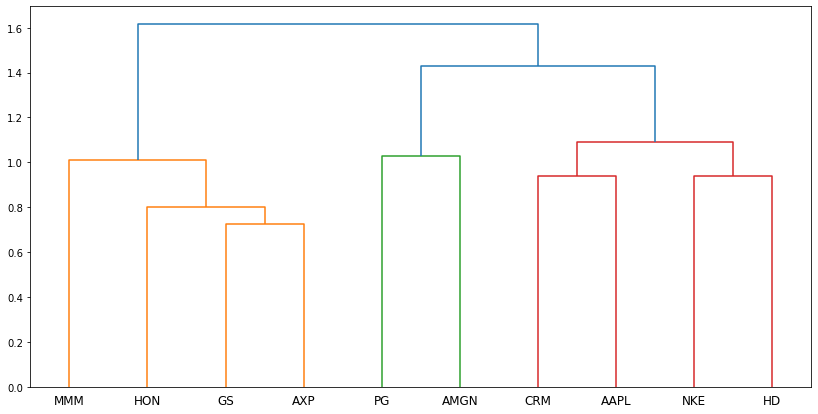

In [1]:
from yahoo_fin import stock_info as si
import pandas as pd
from datetime import datetime
from yahoofinancials import YahooFinancials
import numpy as np
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
from scipy.spatial.distance import squareform, pdist
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import random
from scipy.cluster.hierarchy import fcluster, cophenet
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

# Define the tickers for Apple and Walmart
#"SPMYY", "GWRS"
#tickers = ["MSFT", "WMT", "AAPL", "GOOG", "MEI", "TTE", "ESTE", "JPM", "AON"]
tickers = ["MMM", "GS", "NKE", "AXP", "HD", "PG", "AMGN", "HON", "CRM", "AAPL"]

# Get today's date
today = datetime.today().strftime('%Y-%m-%d')

# Use YahooFinancials to retrieve historic price data for the tickers
price_data = pd.DataFrame()
for ticker in tickers:
    yahoo_financials = YahooFinancials(ticker)
    historic_price_data = yahoo_financials.get_historical_price_data(start_date='2018-01-01', end_date=today, time_interval='daily')
    prices = historic_price_data[ticker]['prices']
    prices_df = pd.DataFrame(prices)
    prices_df = prices_df.set_index('formatted_date')
    prices_df.index.name = 'date'
    prices_df = prices_df['adjclose'].rename(ticker)
    price_data = pd.concat([price_data, prices_df], axis=1)

# Sort the price data by date
price_data = price_data.sort_index()
returns_data = pd.DataFrame()
for i in tickers:
    price_data['rt_'+i] = np.log(price_data[i] / price_data[i].shift(1))
    returns_data = pd.concat([returns_data, price_data['rt_'+i]], axis=1)
cov_matrix = returns_data.cov()
corr_matrix = returns_data.corr()
dist_matrix = np.sqrt(0.5*(1-corr_matrix))
dist_matrix = dist_matrix.values
k = dist_matrix.shape[1]

# Initialize the output matrix D
D = np.zeros((k, k))

# Compute the distance between each pair of columns
for i in range(k):
    for j in range(k):
        d = 0
        for n in range(k):
            d += (dist_matrix[n, i] - dist_matrix[n, j])**2
        D[i, j] = np.sqrt(d)

# Print the output matrix D
distance = pd.DataFrame(D, columns=tickers, index=tickers)
linkage_matrix = sch.linkage(distance, method='ward')
print(linkage_matrix)
plt.figure(figsize=(14, 7))
dendrogram = sch.dendrogram(linkage_matrix, labels=tickers)

rd_sm = np.random.random_sample(size=D.shape)

random_sample = pd.DataFrame(rd_sm, columns=tickers, index=tickers)
linkage_random = sch.linkage(random_sample, method='ward')

print(len(tickers))
#Kmax = len(tickers)//3
Kmax = len(tickers)
print(Kmax)
W = []
gap_stats = np.zeros((Kmax,))
for k in range(1, Kmax):
    labels = fcluster(linkage_matrix, k, criterion='maxclust')
    labels_rm = fcluster(linkage_random, k, criterion='maxclust')
    cluster_distances = []
    cluster_distances_rm = []
    for i,j in zip(np.unique(labels), np.unique(labels_rm)):
        cluster_points = np.where(labels == i)[0]
        cluster_distances.append(D[np.ix_(cluster_points, cluster_points)].sum()/ (2 * len(cluster_points)))
        cluster_points_rm = np.where(labels_rm == j)[0]
        cluster_distances_rm.append(rd_sm[np.ix_(cluster_points_rm, cluster_points_rm)].sum()/ (2 * len(cluster_points_rm)))
    gap_stats[k-1] = np.log(sum(cluster_distances_rm)) - np.log(sum(cluster_distances))
optimal_k = np.argmax(gap_stats)
print("Optimal number of clusters:", optimal_k)
cov_matrix = cov_matrix.rename(index=lambda x: x.replace('rt_', ''))
cov_matrix = cov_matrix.rename(columns=lambda x: x.replace('rt_', ''))

In [2]:
optimal_k = np.argmax(gap_stats)

# Get the cluster labels for each ticker
labels = cut_tree(linkage_matrix, n_clusters=optimal_k)
print(labels.T)
print(tickers)
# Create a list of ticker names sorted by cluster labels
tickers_sorted = []
for i in range(optimal_k):
    tickers_sorted.extend([tickers[j] for j in range(len(tickers)) if labels[j] == i])

# Sort the covariance matrix by the sorted list of tickers
distance_sorted = distance.loc[tickers_sorted, tickers_sorted]
distance_sorted

[[0 1 2 1 3 4 5 1 6 6]]
['MMM', 'GS', 'NKE', 'AXP', 'HD', 'PG', 'AMGN', 'HON', 'CRM', 'AAPL']


,MMM,GS,AXP,HON,NKE,HD,PG,AMGN,CRM,AAPL
MMM,0.000000,0.661983,0.690541,0.581674,0.725886,0.697719,0.785702,0.778446,0.837213,0.757383
GS,0.661983,0.000000,0.511804,0.558367,0.705362,0.672316,0.846397,0.843933,0.795788,0.719801
AXP,0.690541,0.511804,0.000000,0.535925,0.702846,0.699441,0.847819,0.858098,0.803687,0.745446
HON,0.581674,0.558367,0.535925,0.000000,0.677865,0.668009,0.819240,0.817494,0.822780,0.731309
NKE,0.725886,0.705362,0.702846,0.677865,0.000000,0.660721,0.803647,0.844979,0.736609,0.688456
HD,0.697719,0.672316,0.699441,0.668009,0.660721,0.000000,0.753757,0.783327,0.728263,0.657311
PG,0.785702,0.846397,0.847819,0.819240,0.803647,0.753757,0.000000,0.724632,0.853839,0.783916
AMGN,0.778446,0.843933,0.858098,0.817494,0.844979,0.783327,0.724632,0.000000,0.832554,0.777764
CRM,0.837213,0.795788,0.803687,0.822780,0.736609,0.728263,0.853839,0.832554,0.000000,0.648645
AAPL,0.757383,0.719801,0.745446,0.731309,0.688456,0.657311,0.783916,0.777764,0.648645,0.000000


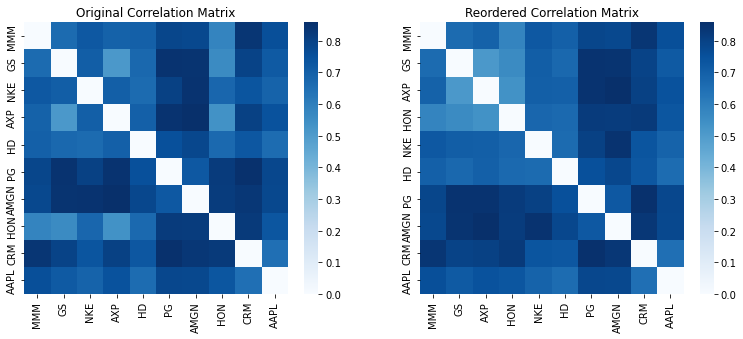

In [3]:
tickers_reor = distance_sorted.columns.tolist()

# plot the original and reordered correlation matrices side-by-side
fig, axs = plt.subplots(ncols=2, figsize=(13, 5))

# plot the original correlation matrix
sns.heatmap(distance, cmap='Blues', ax=axs[0])
axs[0].set_title('Original Correlation Matrix')

# plot the reordered correlation matrix
sns.heatmap(distance_sorted, cmap='Blues', ax=axs[1])
axs[1].set_title('Reordered Correlation Matrix')

plt.show()

In [4]:
indexes = cov_matrix.columns
weights = pd.Series(1, index=indexes)
linkage_matrix = linkage(cov_matrix, method='ward')
labels = cut_tree(linkage_matrix, n_clusters=2)[:, 0]

cItem = [indexes]
while len(cItem) > 0:
    cItem = [cItem[i][labels[cItem[i]] == j] for i in range(len(cItem)) for j in range(2) if len(cItem[i][labels[cItem[i]] == j]) > 1]
    for i in range(0, len(cItem), 2):
        cItem1 = cItem[i] # cluster 1
        cItem2 = cItem[i+1] # cluster 2
        print(cItem1, cItem2)

C:\Users\pp_co\AppData\Local\Temp\ipykernel_37016\1751025340.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cItem = [cItem[i][labels[cItem[i]] == j] for i in range(len(cItem)) for j in range(2) if len(cItem[i][labels[cItem[i]] == j]) > 1]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [5]:
indexes = cov_matrix.columns
weights = pd.Series(1, index=indexes)
linkage_matrix = sch.linkage(cov_matrix, method='ward')
labels = cut_tree(linkage_matrix, n_clusters=2)
print(labels)
cItem = [indexes[labels == 0], indexes[labels == 1]]
print(cItem)
while len(cItem) > 0:
    cItem_new = []
    for i in range(len(cItem)):
        if len(cItem[i]) > 1:
            linkage_matrix_i = sch.linkage(cov_matrix.loc[cItem[i], cItem[i]], method='ward')
            labels_i = cut_tree(linkage_matrix_i, n_clusters=2).flatten()
            cItem_new.append(cItem[i][labels_i == 0])
            cItem_new.append(cItem[i][labels_i == 1])
        else:
            cItem_new.append(cItem[i])
    cItem = cItem_new
    print(cItem)
    for i in range(0, len(cItem), 2):
        cItem1 = cItem[i]  # cluster 1
        cItem2 = cItem[i+1]  # cluster 2

[[0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [6]:
indexes = cov_reordered.columns
weights=pd.Series(1, index=indexes)
cItem=[indexes]
while len(cItem)>0:
    for i in cItem:
        labels_i = cut_tree(linkage_matrix, n_clusters=2)
        cItem=[i[j:k]]
    cItem=[i[j:k] for i in cItem for j,k in ((0,len(i)//2), (len(i)//2,len(i))) if len(i)>1]
    for i in range(0,len(cItem),2):
        cItem1=cItem[i] # cluster 1
        cItem2=cItem[i+1] # cluster 2 
        
        left_matrix = cov_reordered.loc[cItem1,cItem1]
        right_matrix = cov_reordered.loc[cItem2,cItem2]

        w1=1./np.diag(left_matrix)
        w1/=w1.sum()
        w2=1./np.diag(right_matrix)
        w2/=w2.sum()
        V1 = w1.T @ left_matrix @ w1
        V2 = w2.T @ right_matrix @ w2

        alpha = 1 - (V1/(V1+V2))
        
        weights[cItem1] *= alpha
        weights[cItem2] *= 1-alpha

NameError: name 'cov_reordered' is not defined

## for i in range(5):
    if i == 0:
        labels_i = cut_tree(linkage_matrix, n_clusters=2)
        cov_matrix_i = cov_matrix.loc[labels_i == 0, labels_i == 0]
        cov_matrix_j = cov_matrix.loc[labels_i == 1, labels_i == 1]

    else:
        if len(cov_matrix_i)>1:
            linkage_matrix_i = sch.linkage(cov_matrix_i, method='ward')
            labels_i = cut_tree(linkage_matrix_i, n_clusters=2)
            cov_matrix_i_0 = cov_matrix_i.loc[labels_i == 0, labels_i == 0]
            cov_matrix_i_1 = cov_matrix_i.loc[labels_i == 1, labels_i == 1]
        if len(cov_matrix_j)>1:
            linkage_matrix_j = sch.linkage(cov_matrix_j, method='ward')
            labels_j = cut_tree(linkage_matrix_j, n_clusters=2)
            cov_matrix_j_0 = cov_matrix_j.loc[labels_j == 0, labels_j == 0]
            cov_matrix_j_1 = cov_matrix_j.loc[labels_j == 1, labels_j == 1]
            print(i)
            cov_matrix_i = cov_matrix_i_0
            cov_matrix_j = cov_matrix_j_1
    print(labels_i)
    print(cov_matrix_i)
    print(cov_matrix_j)

In [8]:
for j in range(len(np.unique(labels))-1):
    cluster1_tickers = [tickers[i] for i in range(len(tickers)) if labels[i] == j]
    cluster2_tickers = [tickers[i] for i in range(len(tickers)) if labels[i] == j+1 if (j+1)<=len(labels)]

    cluster1_indices = [i for i in range(len(tickers)) if tickers[i] in cluster1_tickers]
    cluster2_indices = [i for i in range(len(tickers)) if tickers[i] in cluster2_tickers]

    cluster3_distances = distance_sorted.values[cluster1_indices, :][:, cluster2_indices]
    cluster4_distances = cluster3_distances.T
    distance_3_4 = cluster3_distances.mean()
    #print("Distance between clusters:", j, j+1, "\n", distance_3_4)
print(distance)
for i in range(2):
    labels = cut_tree(linkage_matrix, n_clusters=2)
    # Get the rows that belong to cluster i
    cluster_i = cov_matrix.loc[labels == i, labels == i]
    cluster_i_dist = distance.loc[labels == i, labels == i]
    print(cluster_i_dist)
    
    # Perform hierarchical clustering on cluster i
    linkage_matrix_i = sch.linkage(cluster_i_dist, method='ward')
    labels_i = cut_tree(linkage_matrix_i, n_clusters=2)
    print(labels_i)

    for j in range(2):
        # Get the rows that belong to cluster j within cluster i
        cluster_ij = cluster_i.loc[labels_i == j, labels_i == j]
        cluster_ij_dist = cluster_i_dist.loc[labels_i == j, labels_i == j]
        print(cluster_ij_dist)

        
print("\n")
print("NEXTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT")
labels_0 = cut_tree(linkage_matrix, n_clusters=2)
print(labels_0)
# Get the rows that belong to cluster 0
cluster_0 = cov_matrix.loc[labels_0 == 0, labels_0 == 0]
cluster_0_dist = distance.loc[labels_0 == 0, labels_0 == 0]
# Get the rows that belong to cluster 1
cluster_1 = cov_matrix.loc[labels_0 == 1, labels_0 == 1]
cluster_1_dist = distance.loc[labels_0 == 1, labels_0 == 1]

linkage_matrix_0 = sch.linkage(cluster_0_dist, method='ward')
labels_0 = cut_tree(linkage_matrix_0, n_clusters=2)

# Get the rows that belong to cluster 0
cluster_0_0 = cluster_0.loc[labels_0 == 0, labels_0 == 0]
cluster_0_dist_0 = cluster_0_dist.loc[labels_0 == 0, labels_0 == 0]

# Get the rows that belong to cluster 1
cluster_0_1 = cluster_0.loc[labels_0 == 1, labels_0 == 1]
cluster_0_1_dist = cluster_0_dist.loc[labels_0 == 1, labels_0 == 1]


linkage_matrix_1 = sch.linkage(cluster_1_dist, method='ward')
labels_1 = cut_tree(linkage_matrix_1, n_clusters=2)
print(labels_1)
# Get the rows that belong to cluster 0
cluster_1_0 = cluster_1.loc[labels_1 == 0, labels_1 == 0]
cluster_1_dist_0 = cluster_1_dist.loc[labels_1 == 0, labels_1 == 0]
print(cluster_1_dist_0)
# Get the rows that belong to cluster 1
cluster_1_1 = cluster_1.loc[labels_1 == 1, labels_1 == 1]
cluster_1_1_dist = cluster_1_dist.loc[labels_1 == 1, labels_1 == 1]
print(cluster_1_1_dist)


           MMM        GS       NKE       AXP        HD        PG      AMGN  \
MMM   0.000000  0.661983  0.725886  0.690541  0.697719  0.785702  0.778446   
GS    0.661983  0.000000  0.705362  0.511804  0.672316  0.846397  0.843933   
NKE   0.725886  0.705362  0.000000  0.702846  0.660721  0.803647  0.844979   
AXP   0.690541  0.511804  0.702846  0.000000  0.699441  0.847819  0.858098   
HD    0.697719  0.672316  0.660721  0.699441  0.000000  0.753757  0.783327   
PG    0.785702  0.846397  0.803647  0.847819  0.753757  0.000000  0.724632   
AMGN  0.778446  0.843933  0.844979  0.858098  0.783327  0.724632  0.000000   
HON   0.581674  0.558367  0.677865  0.535925  0.668009  0.819240  0.817494   
CRM   0.837213  0.795788  0.736609  0.803687  0.728263  0.853839  0.832554   
AAPL  0.757383  0.719801  0.688456  0.745446  0.657311  0.783916  0.777764   

           HON       CRM      AAPL  
MMM   0.581674  0.837213  0.757383  
GS    0.558367  0.795788  0.719801  
NKE   0.677865  0.736609  0.68

C:\Users\pp_co\AppData\Local\Temp\ipykernel_37016\3107965065.py:21: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix_i = sch.linkage(cluster_i_dist, method='ward')
C:\Users\pp_co\AppData\Local\Temp\ipykernel_37016\3107965065.py:21: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix_i = sch.linkage(cluster_i_dist, method='ward')
C:\Users\pp_co\AppData\Local\Temp\ipykernel_37016\3107965065.py:43: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix_0 = sch.linkage(cluster_0_dist, method='ward')
C:\Users\pp_co\AppData\Local\Temp\ipykernel_37016\3107965065.py:55: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an unconden